# Retrieval of the TOA Reflectance from the MYD02HKM data

The SARA is based on the satellite received spectral reflectance (ρλ), which is a func- tion of measured spectral radiance (LTOA(λ)), solar zenith angle, earth–sun distance in astronomical unit and mean solar exoatmospheric radiation (Eq. 1):

$\rho_{TOA(\lambda)} = \frac{\pi L_{TOA(\lambda)}d^2}{ESUN_{\lambda}\mu_s}$

where $\rho_{TOA(\lambda)}$ = satellite received TOA spectral reflectance, $L_{TOA(\lambda)}$ = satellite received TOA spectral radiance, $ESUN_{\lambda}$ = mean solar exoatmospheric radiation radiation as a function of MODIS band number. For MODIS band 4, the $ESUN_{\lambda}$ value is 1850 (*Tasumi et al., 2008*). $μ_s$ = cosine of solar zenith angle.

Parameter $d^2$ can be calculated as a function of day of year using Duffie and Beckman 􏰀1991􏰁 (Eq. 2):

$d^2 = \frac{1}{1+0.033 \cos(DOY\cdot 2\pi /365)}$

where $DOY$ = day of year and 􏰀$DOY·2􏰘/365􏰁$ 􏰀(rad􏰁)


In [3]:
%matplotlib inline
import readData as rd
import math
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd

## Load Data

In [4]:
MYD02HKM = rd.read_data('MYD02HKM')
MYD03 = rd.read_data('MYD03')
MYD02_E_LUTs = rd.read_data('MYD02_Emissive_LUTs', LUT_mode=True)
MYD02_R_LUTs = rd.read_data('MYD02_Reflective_LUTs', LUT_mode=True)
MYD02_Q_LUTs = rd.read_data('MYD02_QA_LUTs', LUT_mode=True)
# MYD09GA = rd.read_data('MYD09GA')

MYD02HKM/MYD02HKM.A2019299.2130.061.2019300153603.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019302.2020.061.2019303155337.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019306.2135.061.2019307150842.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019300.2030.061.2019301152343.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019301.2115.061.2019302151923.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019309.2025.061.2019310152027.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019302.2200.061.2019303153950.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019303.2105.061.2019304153027.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019298.2045.061.2019299151631.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019307.2040.061.2019308152443.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019304.2145.061.2019305151204.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019304.2010.061.2019305151339.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019299.2125.061.2019300153403.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019303.2100.061.20

In [5]:
print('--- MYD02 Reflective LUTs ---')
for item in MYD02_R_LUTs[0]['dataset_list']:
    print(item[1])

--- MYD02 Reflective LUTs ---
[281x1340] m1 (32-bit floating-point)
[191x22x40x2x5] RVS_RefSB (32-bit floating-point)
[1x10] SWIR_OOB_corr_sending_detector (16-bit integer)
[4x20x2x2] X_OOB_0 (32-bit floating-point)
[4x20x2x2] X_OOB_1 (32-bit floating-point)
[4x20x2x2] X_OOB_2 (32-bit floating-point)
[9x1340] dn_sat_ev (64-bit floating-point)
[1x10] B26_B5_Corr (32-bit floating-point)
[1x1] B26_B5_Corr_Switch (16-bit integer)
[1x330] u1 (32-bit floating-point)
[23x330x2x7] u2 (32-bit floating-point)
[1x330x2] u3 (32-bit floating-point)
[23x22x40x4x2x3] u4 (32-bit floating-point)
[1x4] swir_ui_factor (32-bit floating-point)


According to the LUT provided by the MODIS Characterization Support Team (MCST), the data in scaled integer bands should be converted. 

For MODIS band 4, the values of the DN are scaled from \[0, 4095\] to \[0, 32767]. In this regard, we need to covert the data back to its correct values. 

In [6]:
data02 = rd.openSubDataset(MYD02HKM[0]['dataset_list'], 4)
corrected_counts_scale = 4095 / 32767
corrected_counts_offset = - ( 32767 * 0 ) / ( 4095 )
data02 = data02 / 32767 * 4095
year = MYD02HKM[0]['year']
dofy = MYD02HKM[0]['dofy']
hour = MYD02HKM[0]['hour']
minute = MYD02HKM[0]['minute']

data03meta = rd.search_data(MYD03, year, dofy, hour, minute)
sensorZenith = rd.openSubDataset(data03meta[0]['dataset_list'], 3)
sensorZenith = rd.resample_integral_multiple(sensorZenith, 2)
sensorAzimuth = rd.openSubDataset(data03meta[0]['dataset_list'], 4)
sensorAzimuth = rd.resample_integral_multiple(sensorAzimuth, 2)
solarZenith = rd.openSubDataset(data03meta[0]['dataset_list'], 6)
solarZenith = rd.resample_integral_multiple(solarZenith, 2)
solarAzimuth = rd.openSubDataset(data03meta[0]['dataset_list'], 7)
solarAzimuth = rd.resample_integral_multiple(solarAzimuth, 2)

# Convert the angles to radians.
sensorZenith = rd.to_radian(sensorZenith)
sensorAzimuth = rd.to_radian(sensorAzimuth)
solarZenith = rd.to_radian(solarZenith)
solarAzimuth = rd.to_radian(solarAzimuth)


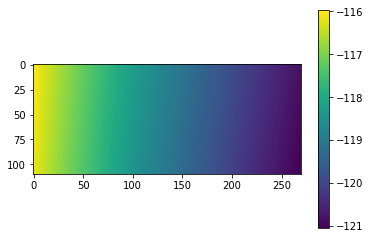

In [7]:
lat = rd.openSubDataset(MYD02HKM[0]['dataset_list'], 2)
lon = rd.openSubDataset(MYD02HKM[0]['dataset_list'], 3)

plt.imshow(lon)
plt.colorbar()

## Data Exploration

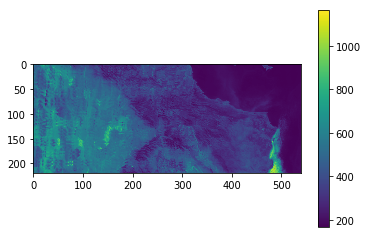

In [8]:
plt.imshow(data02)
plt.colorbar()

/Users/weiye/.conda/envs/New37/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


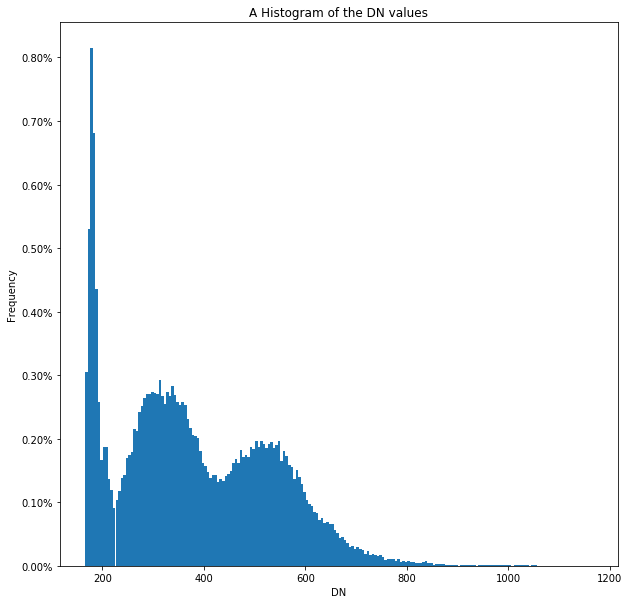

In [9]:
rd.show_histogram(data02)

In [10]:
rd.show_descriptives(data02)

                   0
count  118800.000000
mean      381.517313
std       151.947966
min       165.839564
25%       262.193976
50%       357.548601
75%       502.267678
max      1165.500961


In [11]:
d2 = 2 * math.pi * dofy / 365
d2 = 0.033 * math.cos(d2) + 1
d2 = 1 / d2
print("d^2 = ", d2)
ESUN = 1850
print('ESUN = ', ESUN)
# µ_v = pd.DataFrame(np.cos(solarZenith.values / 180 * math.pi / 100))
µ_s = np.cos(solarZenith)
µ_v = np.cos(sensorZenith)

d^2 =  0.9862941325040683
ESUN =  1850


                   0
count  118800.000000
mean        1.096661
std         0.452228
min         0.458497
25%         0.743550
50%         1.015613
75%         1.458994
max         3.281781


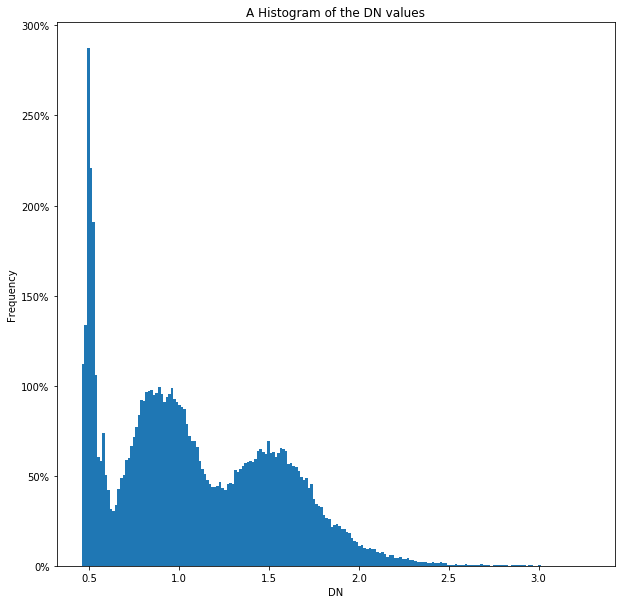

In [12]:
rho_TOA = math.pi * data02 * d2 / (ESUN * µ_s)
rd.show_histogram(rho_TOA)
rd.show_descriptives(rho_TOA)

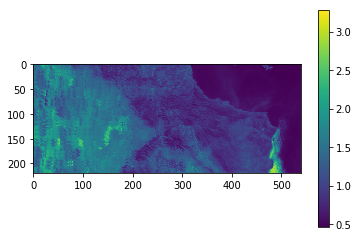

In [13]:
plt.imshow(rho_TOA)
plt.colorbar()

# Rayleigh Reflectance

### **Calculating the scattering Angle**

According to [Levy et. al](https://doi.org/10.1029/2006JD007811), the scattering angle could be calculated from the following function:

$\Theta = \cos^{-1} (-\cos \theta_0\cos\theta + \sin \theta_0 \sin \theta \cos \phi)$

where $θ_0$, $θ$, and $ϕ$ are the **solar zenith**, **sensor view zenith**, and **relative azimuth angles**, respectively. 
Relative azimuth could be computed by using this function:

$\phi = sensor_{az} - solar_{az} - 180$
http://oceancolor.gsfc.nasa.gov/forum/oceancolor/topic_show.pl?pid=12697;hl=scattering%20angle#pid12697

The Rayleigh reflectance could be calculated from the following equation:
> Bilal, M.; Nazeer, M.; Nichol, J.E.; Bleiweiss, M.P.; Qiu, Z.; Jäkel, E.; Campbell, J.R.; Atique, L.; Huang, X.; Lolli, S. A Simplified and Robust Surface Reflectance Estimation Method (SREM) for Use over Diverse Land Surfaces Using Multi-Sensor Data. Remote Sens. 2019, 11, 1344.

$\rho_R = P_R \cdot \frac{1 - e^{-M\tau_r}}{4(\mu_s + \mu_v)}$

where M = air mass = $\frac1{\mu_s}+ \frac1{\mu_v}$, 

$\tau_r$ = Rayleigh optical depth = $0.008569\lambda^{-4}(1 + 0.0113\lambda^{-2} + 0.0013\lambda^{-4})$, $\lambda$ is in radian; 

$P_R$ is the Rayleigh phase function = $\frac{3A}{4+B}(1 + \cos^2\Theta)$;

A and B are coefficients that account for the molecular asymmetry: $A = 0.9587256,\ B = 1−A$



                   0
count  118800.000000
mean        0.033600
std         0.004665
min         0.028274
25%         0.029538
50%         0.032152
75%         0.036880
max         0.045318


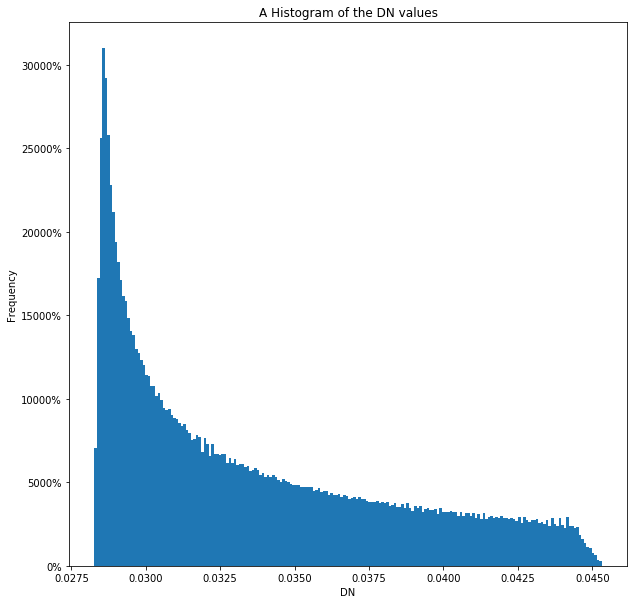

In [14]:
phi = sensorZenith - solarAzimuth - math.pi
cos_phi = np.cos(phi)
cos_Theta = -np.cos(solarZenith) * np.cos(sensorZenith) + np.sin(solarZenith) * np.sin(sensorZenith) * cos_phi
P_R = 3 * 0.9587256 / (5 - 0.9587256) * (1 + cos_Theta * cos_Theta)
wavelen = 0.555
tau_r = 0.008569 * math.pow(wavelen, -4) * (1 + 0.0113 * math.pow(wavelen, -2) + 0.0013 * math.pow(wavelen, -4))
M = 1/µ_v + 1/µ_s
rho_Ray = P_R * (1 - np.power(math.e, - M * tau_r)) / (4 * (µ_s + µ_v))

rd.show_descriptives(rho_Ray)
rd.show_histogram(rho_Ray)

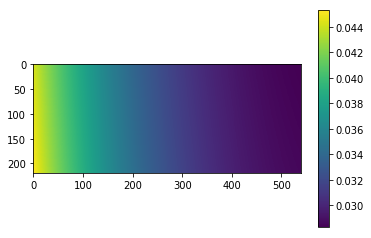

In [15]:
plt.imshow(rho_Ray)
plt.colorbar()

In [16]:
GCPs = rd.generateGCPs(lat, lon)
rd.matrix_to_geo_tiff('what.tif', rho_TOA, GCP=GCPs)


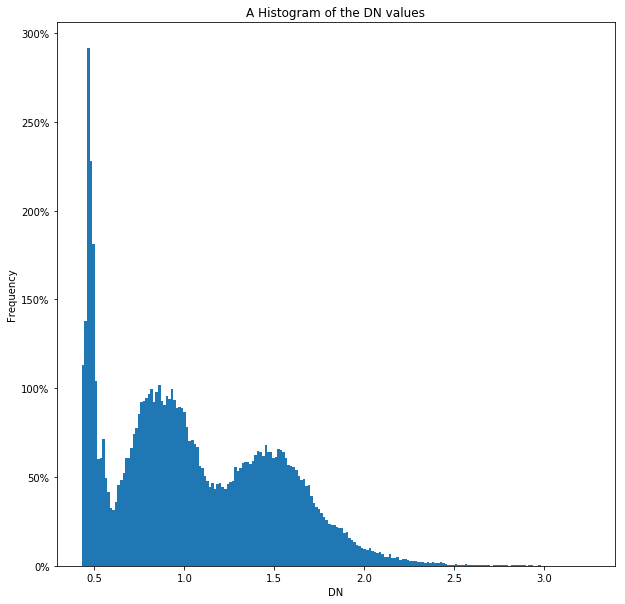

In [17]:
rd.show_histogram(rho_TOA - rho_Ray)
